In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.lines import Line2D

In [2]:
# Default parameter for matplotlib
mpl.rcParams['figure.dpi'] = 100

In [3]:
with open('/home/chenghung/DoTA/input/rf_data/human_weight_rf_data_filtered.pickle', mode='rb') as fh:
    x_data, y, tf_list = pickle.load(fh)

In [4]:
# Create psi table
psi_df = y.pivot(index='Gene', columns='Tissue')['PSI']

In [5]:
# Calculate stdev
psi_stdev = psi_df.std(axis=1, ddof=0)

# Drop genes with no stdev across different tissues
keep_idx = psi_stdev[psi_stdev != 0].index
psi_df = psi_df.loc[keep_idx]
psi_stdev = psi_stdev[keep_idx]
psi_mean = psi_df.mean(axis=1)

In [82]:
# Sort by PSI mean
psi_df = psi_df.loc[psi_mean.sort_values().index]

In [83]:
# Z-score
zpsi_df = psi_df.apply(lambda x: (x - psi_mean[x.name]) / psi_stdev[x.name], axis=1)

In [10]:
# Create table for ploting
psi_data = zpsi_df.reset_index(drop=True).T.melt(var_name='sample', value_name='zpsi').dropna()
psi_data['psi'] = psi_df.reset_index(drop=True).T.melt(var_name='sample', value_name='psi').dropna()['psi']
psi_data = psi_data[psi_data['zpsi'].abs() > 1]

In [15]:
# Set color code for different SD groups
psi_data['color'] = 'tab:blue'
psi_data.loc[(psi_data['zpsi'] < 0), 'color'] = 'tab:red'

In [143]:
positive_group = psi_data.groupby('color').count()['sample'][0]
negative_group = psi_data.groupby('color').count()['sample'][1]
total_remain = positive_group + negative_group

print('Genes:', len(psi_data['sample'].unique()))
print('Events:', total_remain)
print('Positive counts:', positive_group,
      "{0:.2f}".format(positive_group/ len(y) * 100), '%')
print('Negative counts:', negative_group,
      "{0:.2f}".format(negative_group/ len(y) * 100), '%')
print('Discarded counts:', len(y) - total_remain,
      "{0:.2f}".format((len(y) - total_remain) / len(y) * 100), '%')


Genes: 7437
Events: 23332
Positive counts: 12069 14.21 %
negative counts: 11263 13.26 %
Discarded counts: 61618 72.53 %


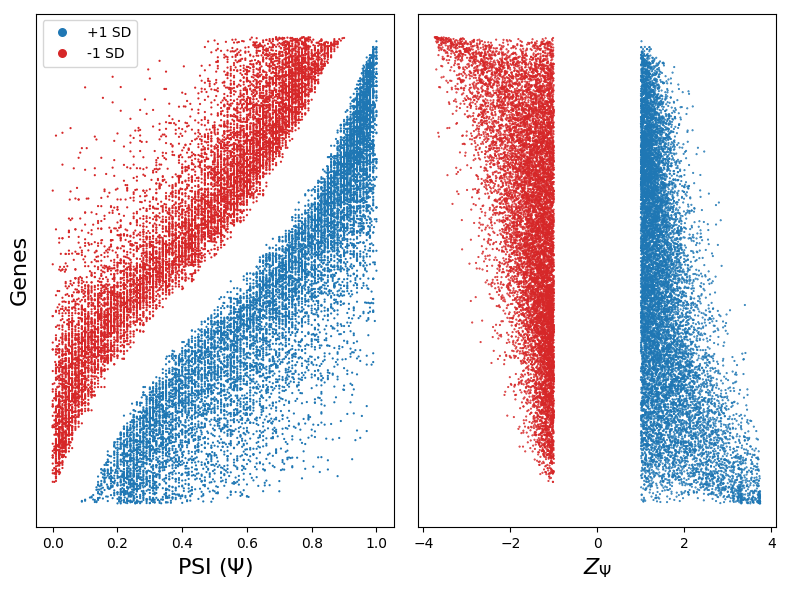

In [30]:
# Shuffle the dataframe for ploting to avoid particular SD group dominant
psi_data = psi_data.sample(frac=1)

# Legend handler
legend_elements = [Line2D([], [], color='w', marker='.',
                          markerfacecolor='tab:blue', markersize=15, label='+1 SD'),
                   Line2D([], [], color='w', marker='.',
                          markerfacecolor='tab:red', markersize=15, label='-1 SD')]

# Scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,6))
plt.yticks([])

ax1.scatter(x=psi_data['psi'], y=psi_data['sample'],
            s=10, c=psi_data['color'], label=psi_data['color'],
            marker='.', edgecolors='none')
ax1.set_xlabel(r'PSI ($\Psi$)', fontsize=16)
ax1.set_ylabel('Genes', fontsize=16)
ax1.legend(handles=legend_elements)

ax2.scatter(x=psi_data['zpsi'], y=psi_data['sample'], s=1, c=psi_data['color'], marker='.')
ax2.set_xlabel(r'$Z_{\Psi}$', fontsize=16)

fig.tight_layout()
# fig.savefig('psi_scatterplot.png', dpi=300)
plt.show()

In [127]:
event_counts_per_gene = zpsi_df[zpsi_df.abs() >= 1].T.melt().dropna().groupby('Gene').count()

In [130]:
gene_counts_across_tissue = event_counts_per_gene.reset_index().groupby('value').count()
gene_counts_cdf = 100 * gene_counts_across_tissue.cumsum()/event_counts_per_gene.count().values

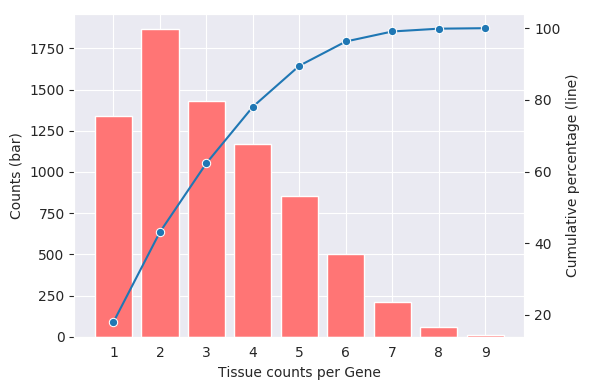

In [132]:
# Estimate tissue counts per gene
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots()
    plt.xlabel('Tissue counts per Gene')
    plt.xticks(range(1, len(gene_counts_across_tissue) + 1))

    ax.bar(gene_counts_across_tissue.index, gene_counts_across_tissue['Gene'], color='#ff7575')
    ax.set_ylabel('Counts (bar)')

    ax2 = plt.twinx()
    ax2 = sns.lineplot(data=gene_counts_cdf, markers='o', legend=False)
    ax2.set_ylabel('Cumulative percentage (line)')
    ax2.grid(None)

    fig.tight_layout()
    # fig.savefig('psi_data_points_stat.png', dpi=300)
    plt.show()